# Neural Network from Scratch Using PyTorch and Custom Dataset

In this activity, you will be introduced to PyTorch basics by implementing a simple neural network using a custom dataset (student pass/fail presented in previous session)

First we install PyTorch along with some other dependencies.

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

### Optional: If CUDA available: False
### 1. Go to the Runtime menu.
### 2. Select Change runtime type.
### 3. Set Hardware accelerator to available GPU and save.

PyTorch version: 2.9.0+cu128
CUDA available: False


and also our function to generate our custom dataset

In [2]:
def generate_pass_fail_dataset(n_samples=100, random_state=42):
    # Ensure n_samples is even for equal split
    n_samples = n_samples if n_samples % 2 == 0 else n_samples + 1
    n_per_class = n_samples // 2

    # Generate FAIL samples (low study hours, low attendance)
    # Students who DON'T meet: study_hours > 5 AND attendance > 70%
    fail_study_hours = np.random.normal(loc=3, scale=1.5, size=n_per_class) #most study around 3 hours, values range from 0-6 hours
    fail_study_hours = np.clip(fail_study_hours, 0, 6)  # Keep mostly below 5

    fail_attendance = np.random.normal(loc=50, scale=15, size=n_per_class)
    fail_attendance = np.clip(fail_attendance, 0, 75)  # Keep mostly below 70%
    fail_labels = np.zeros(n_per_class, dtype=int)

    # Generate PASS samples (high study hours, high attendance)
    # Students who meet: study_hours > 5 AND attendance > 70%
    pass_study_hours = np.random.normal(loc=7.5, scale=1.2, size=n_per_class)
    pass_study_hours = np.clip(pass_study_hours, 5, 10)  # Keep mostly above 5

    pass_attendance = np.random.normal(loc=85, scale=10, size=n_per_class)
    pass_attendance = np.clip(pass_attendance, 70, 100)  # Keep mostly above 70%

    pass_labels = np.ones(n_per_class, dtype=int)

    # Combine both classes
    study_hours = np.concatenate([fail_study_hours, pass_study_hours])
    attendance_rate = np.concatenate([fail_attendance, pass_attendance])
    y = np.concatenate([fail_labels, pass_labels])

    # Shuffle the data
    shuffle_idx = np.random.permutation(n_samples)
    study_hours = study_hours[shuffle_idx]
    attendance_rate = attendance_rate[shuffle_idx]
    y = y[shuffle_idx]

    # Combine features into a matrix
    X = np.column_stack((study_hours, attendance_rate))
    df = pd.DataFrame({'study_hours': study_hours, 'attendance_rate': attendance_rate, 'label': y})

    return X, y, df

## What is PyTorch?

PyTorch is a machine learning library, like TensorFlow. At its core, PyTorch provides an interface for creating and manipulating [tensors](https://pytorch.org/docs/stable/tensors.html), which are data structures that you can think of as multi-dimensional arrays.

Tensors are represented as n-dimensional arrays of base datatypes such as a string or integer -- they provide a way to generalize vectors and matrices to higher dimensions. PyTorch provides the ability to perform computation on these tensors, define neural networks, and train them efficiently.

The [```shape```](https://pytorch.org/docs/stable/generated/torch.Tensor.shape.html#torch.Tensor.shape) of a PyTorch tensor defines its number of dimensions and the size of each dimension. The `ndim` or [```dim```](https://pytorch.org/docs/stable/generated/torch.Tensor.dim.html#torch.Tensor.dim) of a PyTorch tensor provides the number of dimensions (n-dimensions) -- this is equivalent to the tensor's rank (as is used in TensorFlow), and you can also think of this as the tensor's order or degree.

Let’s start by creating some tensors and inspecting their properties:

In [3]:
integer = torch.tensor(1234)
decimal = torch.tensor(3.14159265359)

print(f"`integer` is a {integer.ndim}-d Tensor: {integer}")
print(f"`decimal` is a {decimal.ndim}-d Tensor: {decimal}")

`integer` is a 0-d Tensor: 1234
`decimal` is a 0-d Tensor: 3.1415927410125732


Vectors and lists can be used to create 1-d tensors:

In [4]:
fibonacci = torch.tensor([1, 1, 2, 3, 5, 8])
count_to_100 = torch.tensor(range(100))

print(f"`fibonacci` is a {fibonacci.ndim}-d Tensor with shape: {fibonacci.shape}")
print(f"`count_to_100` is a {count_to_100.ndim}-d Tensor with shape: {count_to_100.shape}")

`fibonacci` is a 1-d Tensor with shape: torch.Size([6])
`count_to_100` is a 1-d Tensor with shape: torch.Size([100])


Next, let’s create 2-d (i.e., matrices) and higher-rank tensors.

In image processing and computer vision, we will use 4-d Tensors with dimensions corresponding to batch size, number of color channels, image height, and image width.

In [5]:
### Defining higher-order Tensors ###

'''A 2-d Tensor'''
matrix = torch.tensor([[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0]])

'''A 4-d Tensor.'''
#   You can think of this as 10 images where each image is RGB 256 x 256.
images = torch.zeros(10, 3, 256, 256)

assert images.shape == (10, 3, 256, 256), "images is incorrect shape"
print(f"images is a {images.ndim}-d Tensor with shape: {images.shape}")

images is a 4-d Tensor with shape: torch.Size([10, 3, 256, 256])


As you have seen, the `shape` of a tensor provides the number of elements in each tensor dimension. The `shape` is quite useful, and we'll use it often. You can also use slicing to access subtensors within a higher-rank tensor:

In [6]:
row_vector = matrix[1]
column_vector = matrix[:, 1]
scalar = matrix[0, 1]

print(f"`row_vector`: {row_vector}")
print(f"`column_vector`: {column_vector}")
print(f"`scalar`: {scalar}")

`row_vector`: tensor([5., 6., 7., 8.])
`column_vector`: tensor([2., 6.])
`scalar`: 2.0


## Computations on Tensors

A convenient way to think about and visualize computations in a machine learning framework like PyTorch is in terms of graphs. We can define this graph in terms of tensors, which hold data, and the mathematical operations that act on these tensors in some order. Let's look at a simple example, and define this computation using PyTorch:

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/add-graph.png)

In [7]:
# Create the nodes in the graph and initialize values
a = torch.tensor(15)
b = torch.tensor(61)

# Add them!
c1 = torch.add(a, b)
c2 = a + b  # PyTorch overrides the "+" operation so that it is able to act on Tensors
print(f"c1: {c1}")
print(f"c2: {c2}")

c1: 76
c2: 76


Notice how we've created a computation graph consisting of PyTorch operations, and how the output is a tensor with value 76.

Now let's consider a slightly more complicated example:

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/computation-graph.png)

Here, we take two inputs, `a, b`, and compute an output `e`. Each node in the graph represents an operation that takes some input, does some computation, and passes its output to another node.

Let's define a simple function in PyTorch to construct this computation function:

In [8]:
### Defining Tensor computations ###

# A simple computation function
def func(a, b):
    c = torch.add(a, b)
    d = torch.subtract(b, 1)
    e = torch.multiply(c, d)
    return e


Now, we can call this function to execute the computation graph given some inputs `a,b`:

In [9]:
# Consider example values for a,b
a, b = 1.5, 2.5
# Execute the computation
e_out = func(a, b)
print(f"e_out: {e_out}")

e_out: 6.0


Notice how our output is a tensor with value defined by the output of the computation, and that the output has no shape as it is a single scalar value.

## Neural networks in PyTorch

We can also define neural networks in PyTorch. PyTorch uses [``torch.nn.Module``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which serves as a base class for all neural network modules in PyTorch and thus provides a framework for building and training neural networks.

Let's consider the example of a simple perceptron defined by just one dense (aka fully-connected or linear) layer: $ y = \sigma(Wx + b) $, where $W$ represents a matrix of weights, $b$ is a bias, $x$ is the input, $\sigma$ is the sigmoid activation function, and $y$ is the output.

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/computation-graph-2.png)

We will use `torch.nn.Module` to define layers -- the building blocks of neural networks. Layers implement common neural networks operations. In PyTorch, when we implement a layer, we subclass `nn.Module` and define the parameters of the layer as attributes of our new class. We also define and override a function [``forward``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.forward), which will define the forward pass computation that is performed at every step. All classes subclassing `nn.Module` should override the `forward` function.

Let's write a dense layer class to implement a perceptron defined above.

In [10]:
### Defining a dense layer ###

# num_inputs: number of input nodes
# num_outputs: number of output nodes
# x: input to the layer

class OurDenseLayer(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(OurDenseLayer, self).__init__()
        # Define and initialize parameters: a weight matrix W and bias b
        self.W = torch.nn.Parameter(torch.randn(num_inputs, num_outputs))
        self.bias = torch.nn.Parameter(torch.randn(num_outputs))

    def forward(self, x):
        z = torch.matmul(x, self.W) + self.bias
        y = torch.sigmoid(z)
        return y


Now, let's test the output of our layer.

In [11]:
# Define a layer and test the output!
num_inputs = 2
num_outputs = 3
layer = OurDenseLayer(num_inputs, num_outputs)
x_input = torch.tensor([[1, 2.]])
y = layer(x_input)

print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.0088, 0.6150, 0.4654]], grad_fn=<SigmoidBackward0>)


Conveniently, PyTorch has defined a number of ```nn.Modules``` (or Layers) that are commonly used in neural networks, for example a [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) or [`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) module.

Now, instead of using a single ```Module``` to define our simple neural network, we'll use the  [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) module from PyTorch and a single [`nn.Linear` ](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer to define our network. With the `Sequential` API, you can readily create neural networks by stacking together layers like building blocks.

In [12]:
### Defining a neural network using the PyTorch Sequential API ###

# define the number of inputs and outputs
n_input_nodes = 2
n_output_nodes = 3

# Define the model
model = nn.Sequential(
    # linear layer with input size 2 and output size 3
    nn.Linear(n_input_nodes, n_output_nodes),
    # Sigmoid activation function
    nn.Sigmoid()
)


We've defined our model using the Sequential API. Now, we can test it out using an example input:

In [13]:
# Test the model with example input
x_input = torch.tensor([[1, 2.]])
model_output = model(x_input)
print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.0088, 0.6150, 0.4654]], grad_fn=<SigmoidBackward0>)


With PyTorch, we can create more flexible models by subclassing [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The `nn.Module` class allows us to group layers together flexibly to define new architectures.

As we saw earlier with `OurDenseLayer`, we can subclass `nn.Module` to create a class for our model, and then define the forward pass through the network using the `forward` function. Subclassing affords the flexibility to define custom layers, custom training loops, custom activation functions, and custom models. Let's define the same neural network model as above (i.e., Linear layer with an activation function after it), now using subclassing and using PyTorch's built in linear layer from `nn.Linear`.

In [14]:
### Defining a model using subclassing ###

class LinearWithSigmoidActivation(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearWithSigmoidActivation, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        linear_output = self.linear(inputs)
        output = self.activation(linear_output)
        return output


Let's test out our new model, using an example input, setting `n_input_nodes=2` and `n_output_nodes=3` as before.

In [15]:
n_input_nodes = 2
n_output_nodes = 3
model = LinearWithSigmoidActivation(n_input_nodes, n_output_nodes)
x_input = torch.tensor([[1, 2.]])
y = model(x_input)
print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.1707, 0.3634, 0.5268]], grad_fn=<SigmoidBackward0>)


## Automatic Differentiation in PyTorch

In PyTorch, [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html) is used for [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which is critical for training deep learning models with [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

We will use the PyTorch [`.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) method to trace operations for computing gradients. On a tensor, the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) attribute controls whether autograd should record operations on that tensor. When a forward pass is made through the network, PyTorch builds a computational graph dynamically; then, to compute the gradient, the `backward()` method is called to perform backpropagation.

Let's compute the gradient of $ y = x^2 $:

In [16]:
### Gradient computation ###

# y = x^2
# Example: x = 3.0
x = torch.tensor(3.0, requires_grad=True)
y = x ** 2
y.backward()  # Compute the gradient

dy_dx = x.grad
print("dy_dx of y=x^2 at x=3.0 is: ", dy_dx)
assert dy_dx == 6.0


dy_dx of y=x^2 at x=3.0 is:  tensor(6.)


In training neural networks, we use differentiation and stochastic gradient descent (SGD) to optimize a loss function. Now that we have a sense of how PyTorch's autograd can be used to compute and access derivatives, we will look at an example where we use automatic differentiation and SGD to find the minimum of $ L=(x-x_f)^2 $. Here $x_f$ is a variable for a desired value we are trying to optimize for; $L$ represents a loss that we are trying to minimize.

Initializing x=-0.017373640090227127


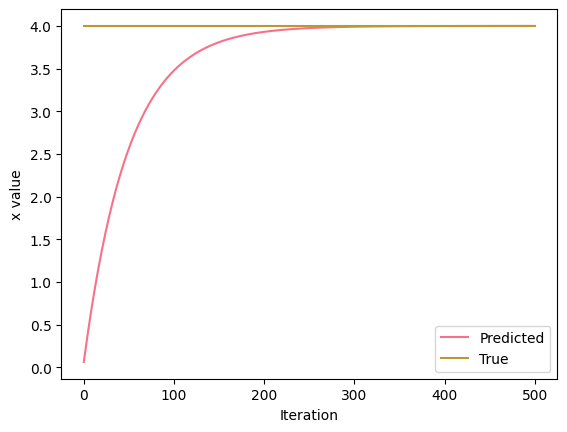

In [17]:
### Function minimization with autograd and gradient descent ###

# Initialize a random value for our intial x
x = torch.randn(1)
print(f"Initializing x={x.item()}")

learning_rate = 1e-2  # Learning rate
history = []
x_f = 4  # Target value


# We will run gradient descent for a number of iterations. At each iteration, we compute the loss,
#   compute the derivative of the loss with respect to x, and perform the update.
for i in range(500):
    x = torch.tensor([x], requires_grad=True)

    # Compute the loss as the square of the difference between x and x_f
    loss = (x - x_f) ** 2

    # Backpropagate through the loss to compute gradients
    loss.backward()

    # Update x with gradient descent
    x = x.item() - learning_rate * x.grad

    history.append(x.item())

# Plot the evolution of x as we optimize toward x_f!
plt.plot(history)
plt.plot([0, 500], [x_f, x_f])
plt.legend(('Predicted', 'True'))
plt.xlabel('Iteration')
plt.ylabel('x value')
plt.show()


# **Activity: Build a student pass/fail classifier**

Build and train a neural network to predict whether a student will pass or fail based on their study hours and attendance rate.

TASKS:
1. Load, explore, and visualize the dataset
2. Prepare the data (convert to tensors, split train/test)
3. Design a neural network architecture
4. Define loss function and optimizer
5. Train the model
6. Evaluate performance
7. Visualize results

In [18]:
# setup

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set plot style
sns.set_theme(style="whitegrid", palette="husl")

# --- DATA GENERATION (from the notebook's provided function) ---
def generate_pass_fail_dataset(n_samples=500, random_state=42):
    """Generates a synthetic dataset for student pass/fail prediction."""
    np.random.seed(random_state)
    # Ensure n_samples is even for equal split
    n_samples = n_samples if n_samples % 2 == 0 else n_samples + 1
    n_per_class = n_samples // 2

    # Generate FAIL samples (low study hours, low attendance)
    # Rule: Pass if study_hours > 5 AND attendance > 70%
    fail_study_hours = np.random.normal(loc=3, scale=1.5, size=n_per_class)
    fail_study_hours = np.clip(fail_study_hours, 0, 6)

    fail_attendance = np.random.normal(loc=50, scale=15, size=n_per_class)
    fail_attendance = np.clip(fail_attendance, 0, 75)
    fail_labels = np.zeros(n_per_class, dtype=int)

    # Generate PASS samples (high study hours, high attendance)
    pass_study_hours = np.random.normal(loc=7.5, scale=1.2, size=n_per_class)
    pass_study_hours = np.clip(pass_study_hours, 5, 10)

    pass_attendance = np.random.normal(loc=85, scale=10, size=n_per_class)
    pass_attendance = np.clip(pass_attendance, 70, 100)
    pass_labels = np.ones(n_per_class, dtype=int)

    # Combine both classes
    study_hours = np.concatenate([fail_study_hours, pass_study_hours])
    attendance_rate = np.concatenate([fail_attendance, pass_attendance])
    y = np.concatenate([fail_labels, pass_labels])

    # Shuffle the data
    shuffle_idx = np.random.permutation(n_samples)
    study_hours = study_hours[shuffle_idx]
    attendance_rate = attendance_rate[shuffle_idx]
    y = y[shuffle_idx]

    # Combine features into a matrix
    X = np.column_stack((study_hours, attendance_rate))
    df = pd.DataFrame({'study_hours': study_hours, 'attendance_rate': attendance_rate, 'label': y})

    return X, y, df

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


--- 📚 TASK 1: Data Loading & Visualization ---
Dataset size: 1000 samples
Feature names: ['study_hours', 'attendance_rate']
Class distribution:
label
1    500
0    500
Name: count, dtype: int64


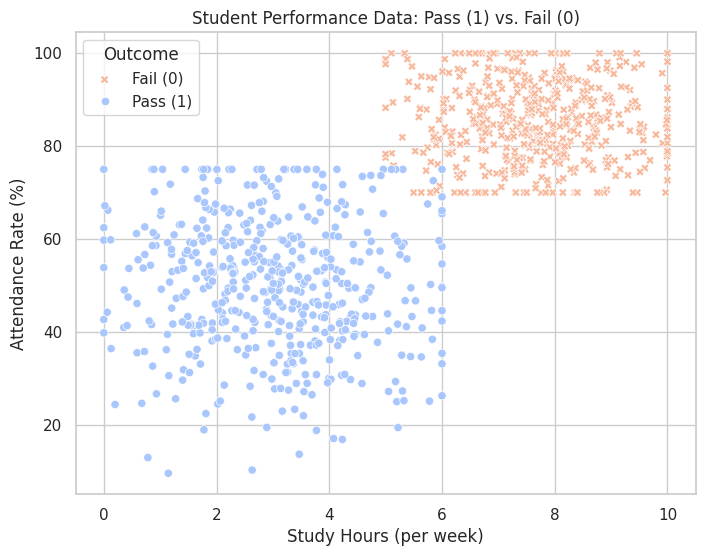

In [19]:
# TASK 1: Load, explore, and visualize the dataset

# --- TASK 1: Load, explore, and visualize the dataset ---
print("--- 📚 TASK 1: Data Loading & Visualization ---")
# Increased sample size for smoother boundary plot
X_np_orig, y_np, df = generate_pass_fail_dataset(n_samples=1000)

print(f"Dataset size: {len(df)} samples")
print(f"Feature names: {list(df.columns[:-1])}")
print(f"Class distribution:\n{df['label'].value_counts()}")

# Visualize the dataset
plt.figure(figsize=(8, 6))
sns.scatterplot(x='study_hours', y='attendance_rate', hue='label', data=df,
                style='label', markers=['o', 'X'], palette='coolwarm')
plt.title('Student Performance Data: Pass (1) vs. Fail (0)')
plt.xlabel('Study Hours (per week)')
plt.ylabel('Attendance Rate (%)')
plt.legend(title='Outcome', labels=['Fail (0)', 'Pass (1)'])
plt.show() # [Image of a scatter plot showing two clearly separable clusters of data points for student pass/fail based on study hours and attendance]

In [20]:
# --- TASK 2: Prepare the data ---

print(f"\n--- ⚙️ TASK 2: Data Preparation ---")
# Normalize/Scale the features (important for NN stability)
X_min = X_np_orig.min(axis=0)
X_max = X_np_orig.max(axis=0)
X_scaled_np = (X_np_orig - X_min) / (X_max - X_min)

# Split data into training and testing sets
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# Convert NumPy arrays to PyTorch Tensors
# Features should be FloatTensor
X_train = torch.FloatTensor(X_train_np).to(device)
X_test = torch.FloatTensor(X_test_np).to(device)

# Labels should be FloatTensor and unsqueezed (size N, 1) for BCEWithLogitsLoss
y_train = torch.FloatTensor(y_train_np).unsqueeze(1).to(device)
y_test = torch.FloatTensor(y_test_np).unsqueeze(1).to(device)

# Create DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Data scaled using Min-Max scaling.")



--- ⚙️ TASK 2: Data Preparation ---
X_train shape: torch.Size([800, 2]), y_train shape: torch.Size([800, 1])
Data scaled using Min-Max scaling.


In [21]:
# --- TASK 3: Implement neural network architecture ---
class StudentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StudentClassifier, self).__init__()
        # Layer 1: Input (2) -> Hidden 1 (8)
        self.fc1 = nn.Linear(input_size, hidden_size1)
        # Layer 2: Hidden 1 (8) -> Hidden 2 (4)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # Layer 3: Hidden 2 (4) -> Output (1)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # ReLU activation for hidden layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # No explicit activation for output, as BCEWithLogitsLoss handles sigmoid internally
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_train.shape[1]  # 2 features
hidden_size1 = 8
hidden_size2 = 4
output_size = 1
model = StudentClassifier(input_size, hidden_size1, hidden_size2, output_size).to(device)

print(f"\n--- 🧠 TASK 3: Model Architecture ---")
print(model)


--- 🧠 TASK 3: Model Architecture ---
StudentClassifier(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)


In [22]:
# --- TASK 4: Implement loss function and optimizer ---
# nn.BCEWithLogitsLoss combines Sigmoid and Binary Cross Entropy for numerical stability
criterion = nn.BCEWithLogitsLoss()
LEARNING_RATE = 0.01
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer

print(f"\n--- 📐 TASK 4: Loss & Optimizer ---")
print(f"Loss Function: {criterion.__class__.__name__} (Sigmoid included)")
print(f"Optimizer: {optimizer.__class__.__name__} with LR={LEARNING_RATE}")


--- 📐 TASK 4: Loss & Optimizer ---
Loss Function: BCEWithLogitsLoss (Sigmoid included)
Optimizer: Adam with LR=0.01


In [23]:
# --- TASK 5: Train the model ---
print(f"\n--- 🚀 TASK 5: Training Model ---")
epochs = 500
loss_history = []
train_accuracy_history = []

for epoch in range(epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass (compute predicted outputs)
        outputs = model(inputs)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass (compute gradient of the loss with respect to parameters)
        loss.backward()

        # 5. Update weights (take a step in the direction of the negative gradient)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy (for tracking)
        # Convert logits to binary predictions
        preds = torch.round(torch.sigmoid(outputs))
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = correct_predictions / total_samples

    loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')

print("Training complete!")


--- 🚀 TASK 5: Training Model ---
Epoch [100/500], Loss: 0.0349, Train Accuracy: 0.9850
Epoch [200/500], Loss: 0.0245, Train Accuracy: 0.9875
Epoch [300/500], Loss: 0.0202, Train Accuracy: 0.9912
Epoch [400/500], Loss: 0.0202, Train Accuracy: 0.9912
Epoch [500/500], Loss: 0.0214, Train Accuracy: 0.9912
Training complete!


In [24]:
# --- TASK 6: Evaluate performance ---
print(f"\n--- ✅ TASK 6: Evaluation ---")
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    # Test set prediction
    test_outputs = model(X_test)
    
    # Calculate test loss
    test_loss = criterion(test_outputs, y_test).item()

    # Convert logits to probabilities using Sigmoid, then to binary predictions
    test_probs = torch.sigmoid(test_outputs)
    test_predictions = torch.round(test_probs)

    # Calculate metrics
    y_test_cpu = y_test.cpu().numpy()
    test_predictions_cpu = test_predictions.cpu().numpy()

    test_accuracy = accuracy_score(y_test_cpu, test_predictions_cpu)
    
    # Other metrics
    precision = precision_score(y_test_cpu, test_predictions_cpu)
    recall = recall_score(y_test_cpu, test_predictions_cpu)
    f1 = f1_score(y_test_cpu, test_predictions_cpu)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")


--- ✅ TASK 6: Evaluation ---
Test Loss: 0.0119
Test Accuracy: 0.9950
Test Precision: 1.0000
Test Recall: 0.9900
Test F1-Score: 0.9950



--- 📊 TASK 7: Visualization ---


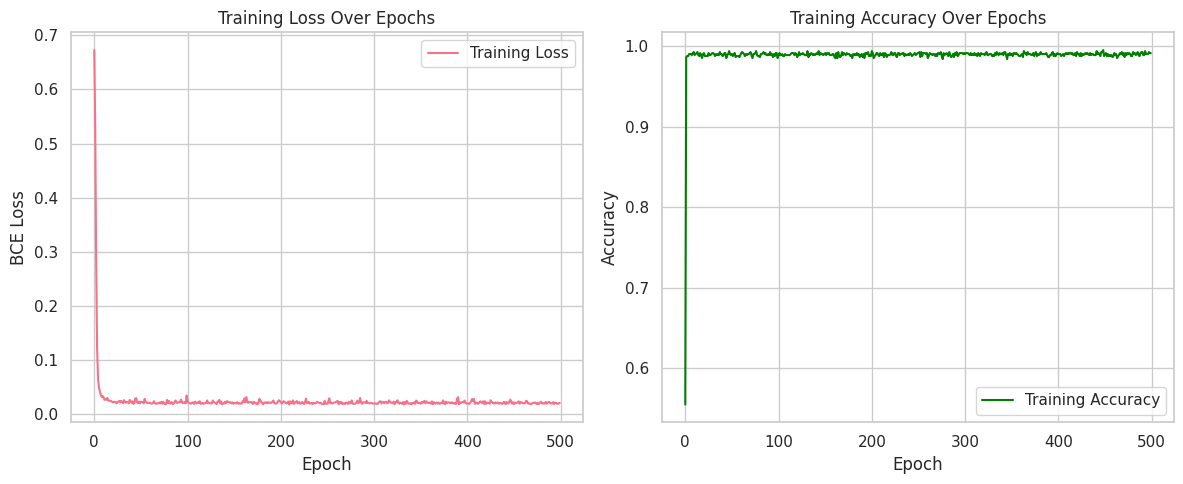

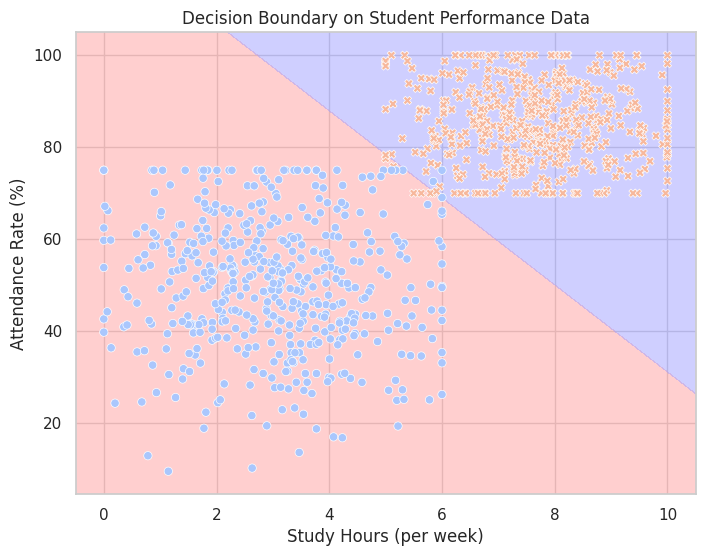

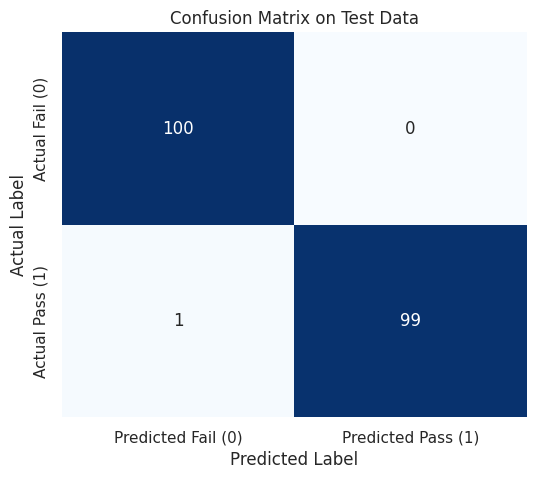

In [25]:
## --- TASK 7: Visualize results (FIXED AND ENHANCED) ---
print(f"\n--- 📊 TASK 7: Visualization ---")

## 7a/7b. Plotting Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy', color='green')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show() # 

## 7c. Plotting the Decision Boundary
def plot_decision_boundary(model, X_orig, y_orig, X_min, X_max, device):
    """Helper function to plot the decision boundary on the original (unscaled) feature space."""
    x_span = np.linspace(X_orig[:, 0].min() - 0.5, X_orig[:, 0].max() + 0.5, 100)
    y_span = np.linspace(X_orig[:, 1].min() - 5, X_orig[:, 1].max() + 5, 100)
    xx, yy = np.meshgrid(x_span, y_span)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = (grid_points - X_min) / (X_max - X_min)
    grid_tensor = torch.FloatTensor(grid_scaled).to(device)

    model.eval()
    with torch.no_grad():
        Z_logits = model(grid_tensor)
        Z_probs = torch.sigmoid(Z_logits)
        Z = Z_probs.cpu().numpy().reshape(xx.shape)
        
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['#FFA0A0', '#A0A0FF'], alpha=0.5)
    sns.scatterplot(x=X_orig[:, 0], y=X_orig[:, 1], hue=y_orig, style=y_orig,
                    markers=['o', 'X'], palette='coolwarm', legend=False)
    
    plt.title('Decision Boundary on Student Performance Data')
    plt.xlabel('Study Hours (per week)')
    plt.ylabel('Attendance Rate (%)')
    plt.show() # 

# Plot the decision boundary
plot_decision_boundary(model, X_np_orig, y_np, X_min, X_max, device)

## 7d. Plotting the Confusion Matrix (New Enhancement)
cm = confusion_matrix(y_test_cpu, test_predictions_cpu)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Fail (0)', 'Predicted Pass (1)'],
            yticklabels=['Actual Fail (0)', 'Actual Pass (1)'])
plt.title('Confusion Matrix on Test Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show() #

**REFLECTION QUESTIONS:**

1. Why do we use sigmoid activation in the output layer for binary classification?

    > We use the Sigmoid activation function because it squashes the raw output (called a logit) of the final linear layer into a probability range between 0 and 1. For binary classification, a value close to 0 indicates the 'Fail' class (0), and a value close to 1 indicates the 'Pass' class (1). This output is then easily interpreted as the probability of the input belonging to the positive class (Pass). In this specific implementation, we used nn.BCEWithLogitsLoss, which mathematically incorporates the Sigmoid, so we skip adding it explicitly to the model's forward function for numerical stability.



2. What would happen if we increased/decreased the number of hidden neurons?

    > Increased Hidden Neurons (Wider Network): The model's capacity (ability to learn complex patterns) increases. This can potentially lead to better performance on complex datasets but raises the risk of overfitting (memorizing the training data, performing poorly on new data). Training time and memory usage will also increase.

    > Decreased Hidden Neurons (Narrower Network): The model's capacity decreases. If the reduction is too severe, the model may underfit (it won't be complex enough to learn the underlying pattern), resulting in high error on both training and test data. Training will be faster.


3. How does the learning rate affect the training process?
    > The learning rate (LR) controls how much the model's weights are adjusted with respect to the gradient of the loss function during each step of optimization.

    >High LR: The model takes large steps in the parameter space. It can lead to overshooting the minimum, causing the loss to diverge or oscillate wildly, and failing to converge to an optimal solution.

    >Low LR: The model takes very small steps. This ensures stable convergence but makes the training process very slow. It might also get stuck in a poor local minimum.

    >Optimal LR: Allows the model to converge quickly and stably to a good minimum.


4. What other metrics besides accuracy could we use to evaluate our model?
    > While accuracy is a good general metric, for binary classification, especially with imbalanced datasets, other metrics provide more insight:

    > Precision: The ratio of correctly predicted positive observations to the total predicted positives (Out of all predicted passes, how many actually passed?).

    > Recall (Sensitivity): The ratio of correctly predicted positive observations to all observations in the actual positive class (Out of all actual passes, how many did we correctly identify?).

    > F1-Score: The harmonic mean of Precision and Recall, useful when you need to balance both.

    > ROC AUC (Area Under the Receiver Operating Characteristic Curve): Measures the trade-off between the true positive rate and the false positive rate, regardless of the classification threshold.

    > Confusion Matrix: A table showing the counts of True Positives, False Negatives, False Positives, and True Negatives.

5. How could we prevent overfitting if we noticed the test loss increasing?
    > verfitting occurs when a model learns the training data too well, including its noise and idiosyncrasies. If the test loss starts increasing while the training loss continues to decrease, the model is overfitting. Methods to prevent this include:

    > Early Stopping: Stop the training process when the performance on a validation/test set starts to degrade, even if the training loss is still decreasing.

    > Regularization (L1/L2): Add a penalty term to the loss function based on the magnitude of the model weights, discouraging overly complex models.

    > Dropout: Randomly set a fraction of neurons to zero during training iterations. This forces the network to learn more robust features.

    > Gathering More Data: The most effective solution, as it provides the model with more examples of the true underlying relationship.

    > Reducing Model Complexity: Use fewer layers or fewer neurons per layer.

---

## **Submission Instructions**

- Upload your completed Notebook to your **GitHub repository**.  
- Ensure the filename follows this format:  
  **`CSC173_Activity02_Lastname_Firstname.ipynb`**
- Make sure all code cells have been executed and outputs are visible.   
- Submit the **GitHub repository link** containing your notebook in the MOLE Assignment page.  
- **Deadline:** *November 3, 2025, 11:59 PM*

---
